## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

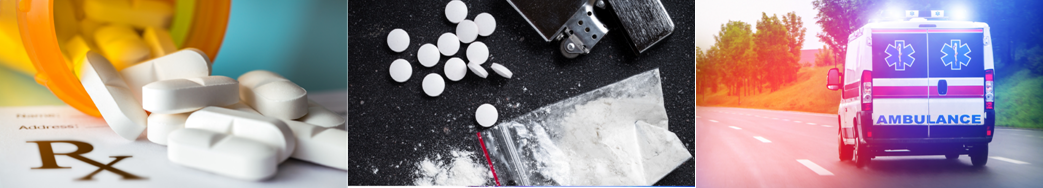

<h1 align=center><font size = 5>Impact of SocioEconomic Factors on Opioid Addiction</font></h1>



## Introduction <a name="introduction"></a>

Between 1999 and 2016, more than 630,000 people died from a drug overdose in the United States. The current epidemic of drug overdoses began in the 1990s with overdose deaths involving prescription opioids, driven by dramatic increases in prescribing of opioids for chronic pain.  

We will analyze data for 5 years (2013 to 2017) to understand the **opioid prescription rates of health care providers** based on their speciality and the death rates due to opioid addiction.  

We will aslo study the impact of **Socioeconomic indicators** like poverty rates, population change, unemployment rates, and education levels on opioid addiction



## Data <a name="data"></a>

Based on definition of our problem, data that we need:
* opioid drug prescriptions by doctors by speccialtiy
* socioecnomic data
* United states - State, County and Zipcode data


Following data sources will be needed to extract/generate the required information:
* The Centers for Medicare & Medicaid Services (CMS) has prepared a public data set, the Medicare Part D Opioid Prescriber Summary File
* [Socioeconomic Indicator Database!](https://www.ers.usda.gov/data-products/county-level-data-sets/)

* [Income by Race,Household](http://datausa.io/api/data?Geography=01000US:children&measure=Household)

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pandas.io.json import json_normalize
import types

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


#!pip install folium
import folium
 
from folium.plugins import MarkerCluster
#from folium.plugins import CirclePattern

from geopy.geocoders import Nominatim 
import requests

import seaborn as sn

# import k-means from clustering stage
from sklearn.cluster import KMeans

import wget

import os

import os.path
from os import path

from sklearn import linear_model
import statsmodels.api as sm

print('Libraries imported.')

dest_folder  = os.getcwd()

Libraries imported.


# Prep Data for Analysis



## Get Miscellanous data needed for analysis -

### * US State Names and Abbreviations
### * US counties and Zip Codes
###  * Latitude andLongitude 

In [11]:
# Extract zip codes and county names from CV file

file_name = dest_folder + '\Data\county_zip.csv'

df_counties = pd.read_csv(file_name,names=['ZIP','COUNTY','STATE','STCOUNTYFP','CLASSFP'],
                             dtype={"ZIP": str},header=1)
df_county_zip = df_counties.drop(['STATE','CLASSFP'], axis=1) 

df_county_zip['COUNTY'] = df_county_zip['COUNTY'].str.split(' ').str[0].str.strip()
df_county_zip = df_county_zip.astype({"ZIP": str})

df_county_zip.head()

ZIP   COUNTY  STCOUNTYFP
0  36006  Autauga        1001
1  36008  Autauga        1001
2  36022  Autauga        1001
3  36051  Autauga        1001
4  36066  Autauga        1001

In [12]:
# Dounload the state abberivations data for the website if not already done

file_name = dest_folder + '\Data\state_abb.json'


with open(file_name, 'r') as f:
    df=json.load(f)
    df_states = pd.json_normalize(df)
    #df_states = pd.read_csv(file_name)
    df_states.rename(columns={'name':'State Name',
                         'abbreviation':'State'}, inplace=True)

df_states.head()

State Name State
0         Alabama    AL
1          Alaska    AK
2  American Samoa    AS
3         Arizona    AZ
4        Arkansas    AR

In [13]:
# Dounload the state latitudes and Longitudes data for the website if not already done

file_name = dest_folder + '\Data\state_geo.json'

with open(file_name, 'r') as f:
    df=json.load(f)
    df_states_latlon = pd.json_normalize(df)
    
df_states_latlon.rename(columns={'state':'State',
                         'latitude':'Latitude',
                         'longitute':'Longitude'}, inplace=True)

df_states_latlon.head()

State  Latitude  longitude
0      Alaska   61.3850  -152.2683
1     Alabama   32.7990   -86.8073
2    Arkansas   34.9513   -92.3809
3     Arizona   33.7712  -111.3877
4  California   36.1700  -119.7462

In [14]:
# Dounload the state geo coordinates data for the website if not already done

file_name = dest_folder + '\Data\states_geo.json'

with open(file_name, 'r') as f:
    df=json.load(f)
    df_states_coord = pd.json_normalize(df, record_path =['features'])
    
df_states_coord.rename(columns={'properties.NAME':'State Name',
                         'geometry.type':'Geometry',
                         'geometry.coordinates':'Coordinates'}, inplace=True)
df_states_coord = df_states_coord.drop(columns=['properties.GEO_ID','properties.STATE','properties.LSAD','properties.CENSUSAREA'])

df_states_coord.head()

type   State Name      Geometry  \
0  Feature      Arizona       Polygon   
1  Feature     Arkansas       Polygon   
2  Feature   California  MultiPolygon   
3  Feature     Colorado       Polygon   
4  Feature  Connecticut       Polygon   

                                         Coordinates  
0  [[[-112.538593, 37.000674], [-112.534545, 37.0...  
1  [[[-94.042964, 33.019219], [-94.043036, 33.079...  
2  [[[[-120.248484, 33.999329], [-120.247393, 34....  
3  [[[-107.317794, 41.002957], [-107.000606, 41.0...  
4  [[[-72.397428, 42.033302], [-72.198828, 42.030...

In [15]:
# Dounload the state latitudes and Longitudes data for the website if not already done

file_name = dest_folder + '\Data\county_geo.json'

with open(file_name, 'r') as f:
    df=json.load(f)
    df_counties = pd.json_normalize(df, record_path =['features'],)
    
df_counties.rename(columns={'properties.name':'COUNTY',
                         'geometry.type':'Geometry',
                         'geometry.coordinates':'Coordinates'}, inplace=True)

df_counties.head()

type    id   COUNTY Geometry  \
0  Feature  1001  Autauga  Polygon   
1  Feature  1003  Baldwin  Polygon   
2  Feature  1005  Barbour  Polygon   
3  Feature  1007     Bibb  Polygon   
4  Feature  1009   Blount  Polygon   

                                         Coordinates  
0  [[[-86.411786, 32.706342], [-86.411786, 32.410...  
1  [[[-87.76459, 31.298768], [-87.616713, 31.2439...  
2  [[[-85.354736, 32.147694], [-85.053504, 32.065...  
3  [[[-87.063542, 33.248559], [-87.025203, 33.248...  
4  [[[-86.488463, 34.261793], [-86.455601, 34.261...

## Opioid Deaths Dataset

### Downloaded the data for opioid deaths from  [Visit Opioid and Health Indicator Database!](https://opioid.amfar.org/indicator/drugdeaths)

In [16]:
# Extract opioid deaths for US from CSV file to df_opioids data frame
# Filter data for analysis from years 2013 to 2017

file_name = dest_folder + '\Data\opioid_deaths.csv'
df_opioids = pd.read_csv(file_name)
df_opioids = df_opioids.fillna(0)

df_opioid_deaths = df_opioids.drop(['STATE', 'STATEFP', 'COUNTYFP','INDICATOR'],axis=1)

df_opioid_deaths.rename(columns={'STATEABBREVIATION':'State',
                                'YEAR':'Year',
                                'VALUE':'OpioidDeaths'}, inplace=True)

df_opioid_deaths['COUNTY'] = df_opioid_deaths['COUNTY'].str.split(' ').str[0].str.strip()
df_opioid_deaths = df_opioid_deaths.merge(df_county_zip)

df_US_opioid_deaths =  df_opioid_deaths[df_opioid_deaths.Year.isin([2013, 2014, 2015, 2016, 2017])]

df_US_opioid_deaths.head(10)

Year  OpioidDeaths State COUNTY    ZIP  STCOUNTYFP
84  2013           0.0    AL   Bibb  35034        1007
85  2013           0.0    AL   Bibb  35035        1007
86  2013           0.0    AL   Bibb  35042        1007
87  2013           0.0    AL   Bibb  35074        1007
88  2013           0.0    AL   Bibb  35111        1007
89  2013           0.0    AL   Bibb  35115        1007
90  2013           0.0    AL   Bibb  35184        1007
91  2013           0.0    AL   Bibb  35188        1007
92  2013           0.0    AL   Bibb  35456        1007
93  2013           0.0    AL   Bibb  36750        1007

### Clean and extract Opioid Prescription Data

In [17]:
# Extract Opioid precription data from CSV file

file_name = dest_folder + '\Data\opioid_total_us.csv'

df_opioid_total = pd.read_csv(file_name)

df_opioid_total = df_opioid_total.astype({"NPPES_zip_code": str, "NPI":str})


#df_opioid_US = df_opioid_total.merge(df_county_zip, on ='ZIP')


df_opioid_US = pd.merge(df_opioid_total,df_county_zip, left_on='NPPES_zip_code',right_on='ZIP')

df_opioid_US.head(10)


Unnamed: 0         NPI NPPES_last_name NPPES_first_name NPPES_zip_code  \
0           0  1003000126       ENKESHAFI          ARDALAN          21502   
1           1  1003000126       ENKESHAFI          ARDALAN          21502   
2           2  1003000126       ENKESHAFI          ARDALAN          21502   
3           3  1003000126       ENKESHAFI          ARDALAN          21502   
4           4  1003000126       ENKESHAFI          ARDALAN          21502   
5           5  1003000142          KHALIL           RASHID          43623   
6           6  1003000142          KHALIL           RASHID          43623   
7           7  1003000142          KHALIL           RASHID          43623   
8           8  1003000142          KHALIL           RASHID          43623   
9           9  1003000142          KHALIL           RASHID          43623   

  NPPES_state Speciality_Description  YEAR  Total_Claim_Count  \
0          MD      Internal Medicine  2013                363   
1          MD      Internal Medicine  2014                675   
2          MD      Internal Medicine  2015                825   
3          MD      Internal Medicine  2016                545   
4          MD      Internal Medicine  2017                677   
5          OH         Anesthesiology  2013                512   
6          OH         Anesthesiology  2014                937   
7          OH         Anesthesiology  2015               1757   
8          OH         Anesthesiology  2016               1733   
9          OH         Anesthesiology  2017               1946   

   Opioid_Claim_Count  Long-Acting_Opioid_Claim_Count  ZIP_x  COUNTY_x  ZIP_y  \
0                  16                               0  21502  Allegany  21502   
1                  37                               0  21502  Allegany  21502   
2                  38                               0  21502  Allegany  21502   
3                  23                               0  21502  Allegany  21502   
4                  25                               0  21502  Allegany  21502   
5                 252                              29  43623     Lucas  43623   
6                 425                              36  43623     Lucas  43623   
7                 847                             174  43623     Lucas  43623   
8                 941                             165  43623     Lucas  43623   
9                1040                             200  43623     Lucas  43623   

   COUNTY_y  STCOUNTYFP  
0  Allegany       24001  
1  Allegany       24001  
2  Allegany       24001  
3  Allegany       24001  
4  Allegany       24001  
5     Lucas       39095  
6     Lucas       39095  
7     Lucas       39095  
8     Lucas       39095  
9     Lucas       39095

In [18]:
# Filter Columns needed for analysis

df_opioid_US_data_c = df_opioid_US.filter(items=['NPI','NPPES_last_name','NPPES_first_name','NPPES_zip_code','NPPES_state','Speciality_Description',
                                                         'YEAR','COUNTY_x','STCOUNTYFP','Total_Claim_Count','Opioid_Claim_Count','Long-Acting_Opioid_Claim_Count'])

df_opioid_US_data_c.rename(columns={'NPPES_last_name':'Last Name', 'NPPES_first_name':'First Name','NPPES_zip_code':'ZIP',
                                    'NPPES_state': 'State', 'Long-Acting_Opioid_Claim_Count': 'OpioidPrescriptionCount',
                                'Speciality_Description':'Speciality','YEAR':'Year', 'COUNTY_x':'COUNTY'}, inplace=True)

df_opioid_US_data = pd.merge(df_opioid_US_data_c,df_states)
df_opioid_US_data.head(10)

NPI  Last Name First Name    ZIP State         Speciality  Year  \
0  1003000126  ENKESHAFI    ARDALAN  21502    MD  Internal Medicine  2013   
1  1003000126  ENKESHAFI    ARDALAN  21502    MD  Internal Medicine  2014   
2  1003000126  ENKESHAFI    ARDALAN  21502    MD  Internal Medicine  2015   
3  1003000126  ENKESHAFI    ARDALAN  21502    MD  Internal Medicine  2016   
4  1003000126  ENKESHAFI    ARDALAN  21502    MD  Internal Medicine  2017   
5  1003004839    DARNELL    BEVERLY  20895    MD  Internal Medicine  2013   
6  1003004839    DARNELL    BEVERLY  20895    MD  Internal Medicine  2014   
7  1003004839    DARNELL    BEVERLY  20895    MD  Internal Medicine  2015   
8  1003004839    DARNELL    BEVERLY  20895    MD  Internal Medicine  2016   
9  1003004839    DARNELL    BEVERLY  20895    MD  Internal Medicine  2017   

       COUNTY  STCOUNTYFP  Total_Claim_Count  Opioid_Claim_Count  \
0    Allegany       24001                363                  16   
1    Allegany       24001                675                  37   
2    Allegany       24001                825                  38   
3    Allegany       24001                545                  23   
4    Allegany       24001                677                  25   
5  Montgomery       24031               2310                  73   
6  Montgomery       24031               2702                  74   
7  Montgomery       24031               3036                  82   
8  Montgomery       24031               3250                 101   
9  Montgomery       24031               3546                  85   

   OpioidPrescriptionCount State Name  
0                        0   Maryland  
1                        0   Maryland  
2                        0   Maryland  
3                        0   Maryland  
4                        0   Maryland  
5                       15   Maryland  
6                       19   Maryland  
7                       20   Maryland  
8                       20   Maryland  
9                       12   Maryland

In [19]:
# Group opioid death data at COUNTY level

df_opioidDeaths_US_Couty = df_US_opioid_deaths.groupby(['State','COUNTY','Year'])['OpioidDeaths'].sum().reset_index()

df_opioidDeaths_US_Couty.head()

State     COUNTY  Year  OpioidDeaths
0    AK  Aleutians  2013           0.0
1    AK  Aleutians  2014           0.0
2    AK  Aleutians  2015           0.0
3    AK  Aleutians  2016           0.0
4    AK  Aleutians  2017           0.0

### Merge opioid Prescription data and opioid death data

In [20]:
# Group opioid prescription data at COUNTY level

df_opioidPres_US_county = df_opioid_US_data.groupby(['State','State Name','COUNTY','Year','Speciality'])['Total_Claim_Count','Opioid_Claim_Count','OpioidPrescriptionCount'].sum().reset_index()

df_US_county_data = df_opioidPres_US_county.merge(df_opioidDeaths_US_Couty)

df_US_county_data.head()

<ipython-input-20-1c7ce65103c0>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_opioidPres_US_county = df_opioid_US_data.groupby(['State','State Name','COUNTY','Year','Speciality'])['Total_Claim_Count','Opioid_Claim_Count','OpioidPrescriptionCount'].sum().reset_index()


State State Name     COUNTY  Year           Speciality  Total_Claim_Count  \
0    AK     Alaska  Anchorage  2013  Physician Assistant               1764   
1    AK     Alaska  Anchorage  2014  Physician Assistant               2336   
2    AK     Alaska  Anchorage  2015  Physician Assistant               2092   
3    AL    Alabama     Blount  2013          Dermatology               8679   
4    AL    Alabama     Blount  2014          Dermatology               6051   

   Opioid_Claim_Count  OpioidPrescriptionCount  OpioidDeaths  
0                  83                       30         980.0  
1                  57                       17        1160.0  
2                  44                        0        1180.0  
3                  90                        0         403.0  
4                  93                        0         372.0

In [21]:
# Data at the State level

df_US_county_data_c = df_US_county_data.filter(items=['State','State Name','COUNTY','STCOUNTYFP','Year','Total_Claim_Count','Opioid_Claim_Count','OpioidPrescriptionCount','OpioidDeaths'])

df_OpiodDeaths = df_US_county_data_c.groupby(['State','State Name','Year','COUNTY'])['Total_Claim_Count','Opioid_Claim_Count','OpioidPrescriptionCount','OpioidDeaths'].sum().reset_index()

#df_OpiodDeaths = df_OpioidDeaths_county[df_OpioidDeaths_county.State != 'PR']

# Calcualate the rates
df_OpiodDeaths['OpioidPrescriptionRate'] = 100/ df_OpiodDeaths['Total_Claim_Count'] * df_OpiodDeaths['Opioid_Claim_Count']
df_OpiodDeaths['OpioidDeathRate'] = 100/ df_OpiodDeaths['OpioidPrescriptionCount'] * df_OpiodDeaths['OpioidDeaths']

df_OpiodDeaths.head(10)

<ipython-input-21-37459e7929d5>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_OpiodDeaths = df_US_county_data_c.groupby(['State','State Name','Year','COUNTY'])['Total_Claim_Count','Opioid_Claim_Count','OpioidPrescriptionCount','OpioidDeaths'].sum().reset_index()


State State Name  Year     COUNTY  Total_Claim_Count  Opioid_Claim_Count  \
0    AK     Alaska  2013  Anchorage               1764                  83   
1    AK     Alaska  2014  Anchorage               2336                  57   
2    AK     Alaska  2015  Anchorage               2092                  44   
3    AL    Alabama  2013     Blount               8679                  90   
4    AL    Alabama  2013    Calhoun                256                   0   
5    AL    Alabama  2013   Chambers                246                   0   
6    AL    Alabama  2013    Cullman               8679                  90   
7    AL    Alabama  2013   Franklin                 32                   0   
8    AL    Alabama  2013  Jefferson               3493                  63   
9    AL    Alabama  2013        Lee                246                   0   

   OpioidPrescriptionCount  OpioidDeaths  OpioidPrescriptionRate  \
0                       30         980.0                4.705215   
1                       17        1160.0                2.440068   
2                        0        1180.0                2.103250   
3                        0         403.0                1.036986   
4                        0           0.0                0.000000   
5                        0           0.0                0.000000   
6                        0         304.0                1.036986   
7                        0        4060.0                0.000000   
8                        0      154656.0                1.803607   
9                        0        1680.0                0.000000   

   OpioidDeathRate  
0      3266.666667  
1      6823.529412  
2              inf  
3              inf  
4              NaN  
5              NaN  
6              inf  
7              inf  
8              inf  
9              inf

In [22]:
import plotly.express as px

px.choropleth(df_OpiodDeaths,               
              locations="State",               
              color="OpioidDeaths",  
              animation_frame="Year",    
              color_continuous_scale='ylorrd',
              locationmode='USA-states',
              scope="usa",
              title='Opioid Deaths by State',
              height=600            
)





In [23]:
COORDINATES = (37, -102)
MAX_COUNT = len(df_OpiodDeaths)

file_name = dest_folder + '\Data\states_geo.json'
    
COORDINATES = (37, -102)
MAX_COUNT = len(df_OpiodDeaths)

opioid_map = folium.Map(location=COORDINATES, zoom_start=4,tiles='stamenwatercolor')

opioid_map.choropleth(
 geo_data=file_name,
 name='choropleth',
 data=df_OpiodDeaths,
 columns=['State Name', 'OpioidDeaths'],
 key_on='feature.properties.NAME',
 fill_color='OrRd',
 fill_opacity=0.9,
 line_opacity=0.5,
 legend_name='Opioid Deaths by State'
)




opioid_map


In [24]:
COORDINATES = (37, -102)
MAX_COUNT = len(df_OpiodDeaths)

file_name = dest_folder + '\Data\county_geo.json'
    
COORDINATES = (37, -102)
MAX_COUNT = len(df_OpiodDeaths)

opioid_map = folium.Map(location=COORDINATES, zoom_start=4, tiles='stamenwatercolor')

# add tile layers to the map
tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    folium.TileLayer(tile).add_to(opioid_map)

opioid_map.choropleth(
 geo_data=file_name,
 name='choropleth',
 data=df_OpiodDeaths,
 columns=['COUNTY', 'OpioidDeaths'],
 key_on='feature.properties.name',
 fill_color='OrRd',
 fill_opacity=0.9,
 line_opacity=0.5,
 legend_name='Opioid Deaths by COUNTY'
)




opioid_map

#### Socio Economic Data

In [25]:
# Extract SocioEconomic data from CSV file

file_name = dest_folder + '\Data\SocioEconomicData.csv'

df_socioeconomic = pd.read_csv(file_name, dtype={'Unemployed': int,'Employed':int, 'Homeless':int, 'Population':int,
                                                               'In Poverty':int, 'Not In Poverty':int, 'Depression Count':int, 'Insured':int,
                                                               'Uninsured':int, 'No high school diploma':int,'Bachelor\'s degree or higher':int,
                                                               'Bachelor\'s degree or higher':int,'Median Inome':int})

df_socioeconomic_data = df_socioeconomic.drop('Depression Rate',axis=1)
df_socioeconomic_data.head()


State  Unemployed  Employed  Homeless  Population  In Poverty  \
0    AL     1687000   1624000       344     4874747      782000   
1    AK      167000    243000       216      739795       89000   
2    AZ     2185000   2262000      1463     7016270     1108000   
3    AR      990000   1009000       450     3004279      471000   
4    CA    12148000  13237000     35798    39536653     5435000   

   Not in Poverty  Depression Count   Insured  Uninsured  \
0         4038000            324658   4413000     421000   
1          618000             54671    614000      97000   
2         5771000            423081   6057000     834000   
3         2470000            244248   2720000     225000   
4        33708000           2388014  36157000    3031000   

   No high school diploma  Bachelor's degree or higher  Median Income  
0                  681000                       904000          48123  
1                   74000                       147000          73181  
2                  995000                      1560000          56581  
3                  425000                       488000          45869  
4                 6035000                      9643000          71805

In [26]:
# Merge Opiod deaths and SociEcnomic factors

df_data_analysis = pd.merge(df_OpiodDeaths,df_socioeconomic_data)
df_data_analysis.head()

State State Name  Year     COUNTY  Total_Claim_Count  Opioid_Claim_Count  \
0    AK     Alaska  2013  Anchorage               1764                  83   
1    AK     Alaska  2014  Anchorage               2336                  57   
2    AK     Alaska  2015  Anchorage               2092                  44   
3    AL    Alabama  2013     Blount               8679                  90   
4    AL    Alabama  2013    Calhoun                256                   0   

   OpioidPrescriptionCount  OpioidDeaths  OpioidPrescriptionRate  \
0                       30         980.0                4.705215   
1                       17        1160.0                2.440068   
2                        0        1180.0                2.103250   
3                        0         403.0                1.036986   
4                        0           0.0                0.000000   

   OpioidDeathRate  Unemployed  Employed  Homeless  Population  In Poverty  \
0      3266.666667      167000    243000       216      739795       89000   
1      6823.529412      167000    243000       216      739795       89000   
2              inf      167000    243000       216      739795       89000   
3              inf     1687000   1624000       344     4874747      782000   
4              NaN     1687000   1624000       344     4874747      782000   

   Not in Poverty  Depression Count  Insured  Uninsured  \
0          618000             54671   614000      97000   
1          618000             54671   614000      97000   
2          618000             54671   614000      97000   
3         4038000            324658  4413000     421000   
4         4038000            324658  4413000     421000   

   No high school diploma  Bachelor's degree or higher  Median Income  
0                   74000                       147000          73181  
1                   74000                       147000          73181  
2                   74000                       147000          73181  
3                  681000                       904000          48123  
4                  681000                       904000          48123

## Analysis <a name="analysis"></a>

In [59]:
df_data_analysis['OpioidPrescriptionRate'] = 100/ df_data_analysis['Population'] * df_data_analysis['OpioidPrescriptionCount']
df_data_analysis['OpioidDeathRate'] = 100/ df_data_analysis['Population'] * df_data_analysis['OpioidDeaths']
df_data_analysis['Unemployment Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Unemployed']
df_data_analysis['Employment Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Employed']
df_data_analysis['Homeless Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Homeless']
df_data_analysis['Poverty Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['In Poverty']
df_data_analysis['Depression Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Depression Count']
df_data_analysis['Insured Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Insured']
df_data_analysis['Uninsured Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Uninsured']
df_data_analysis['HS Dropout Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['No high school diploma']
df_data_analysis['Degree Rate'] = 100/ df_data_analysis['Population'] * df_data_analysis['Bachelor\'s degree or higher']
''
df_data_analysis_slice = df_data_analysis.filter(items=['State','State Name','Population','OpioidPrescriptionRate','OpioidDeathRate', 'Unemployment Rate','Employment Rate',
                                                       'Homeless Rate','Poverty Rate','Depression Rate',
                                                       'Insured Rate','Uninsured Rate','HS Dropout Rate','Degree Rate'])  
df_data_analysis_slice.head()

df = df_data_analysis.filter(items=['Population','OpioidPrescriptionRate','OpioidDeathRate', 'Unemployment Rate','Employment Rate',
                                                       'Homeless Rate','Poverty Rate','Depression Rate',
                                                       'Insured Rate','Uninsured Rate','HS Dropout Rate','Degree Rate'])
                                                                                        

#### Plot the random distributions of input features

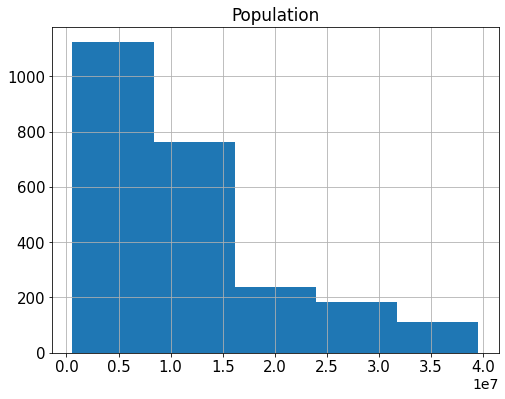

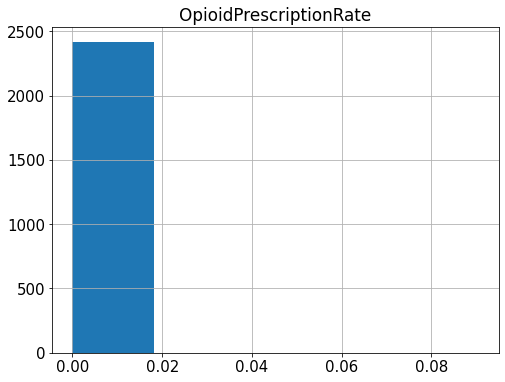

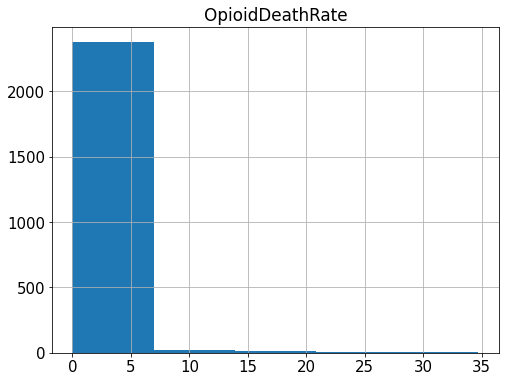

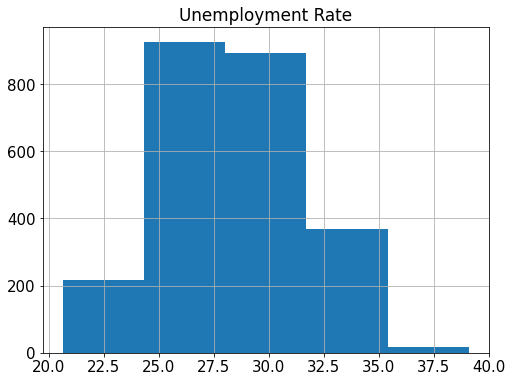

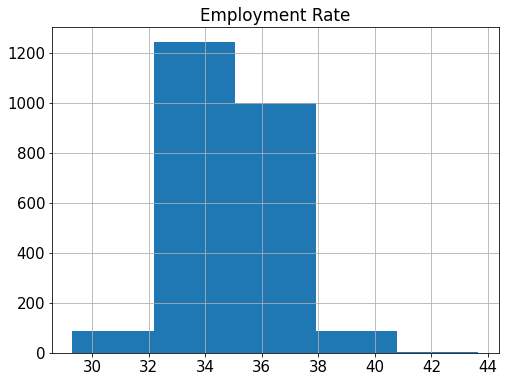

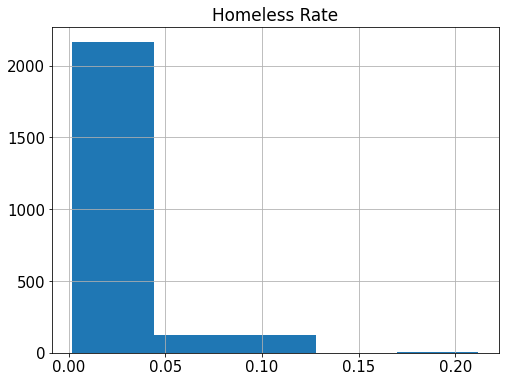

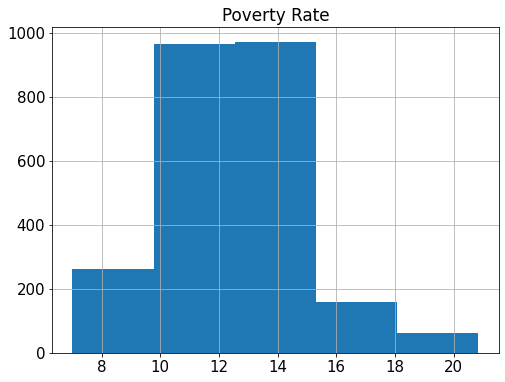

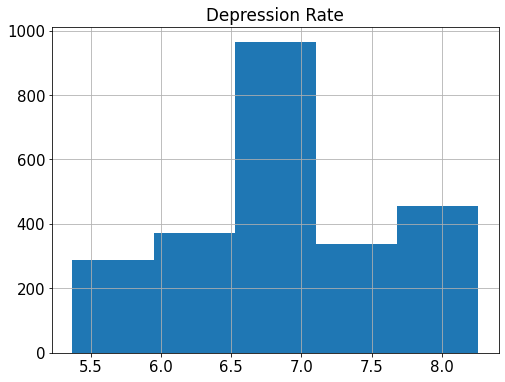

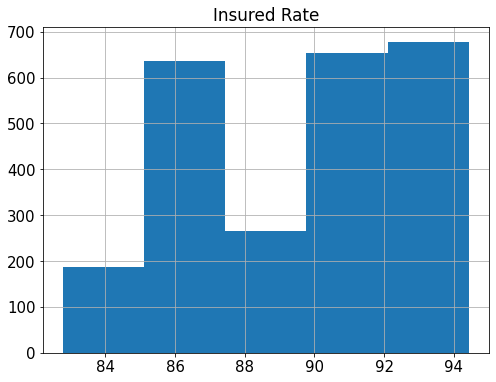

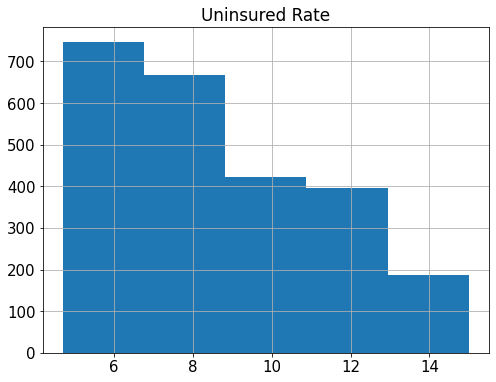

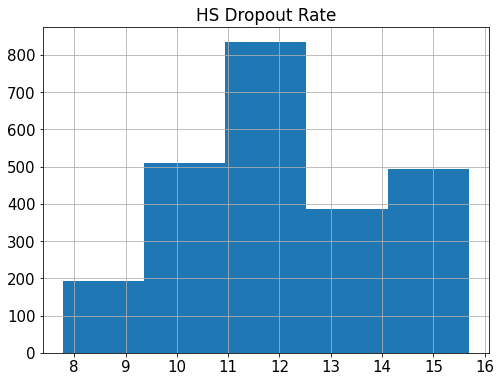

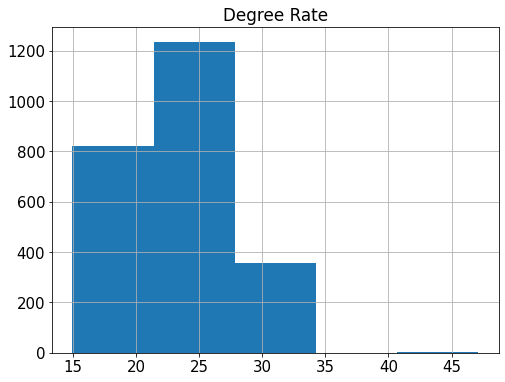

In [60]:
for i in df.columns:
    df.hist(i,bins=5,xlabelsize=15,ylabelsize=15,figsize=(8,6))

#### Plot single-variable scatterplots

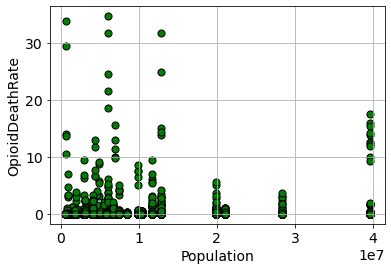

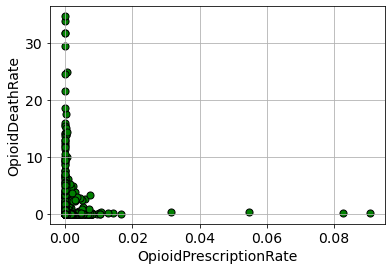

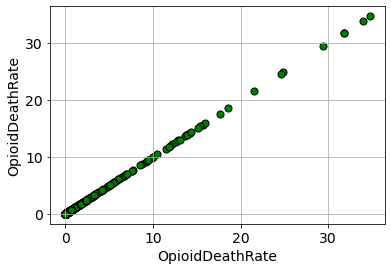

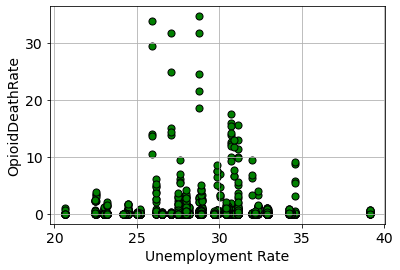

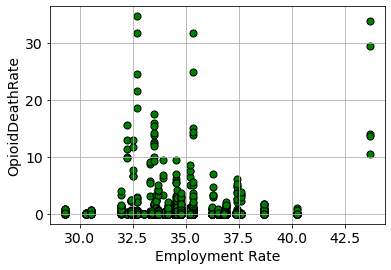

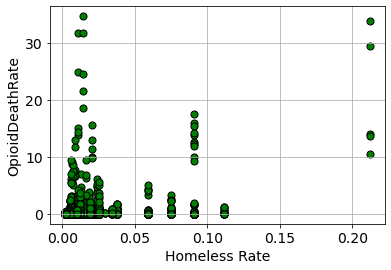

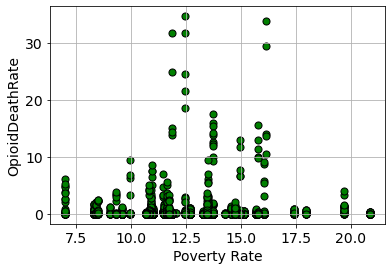

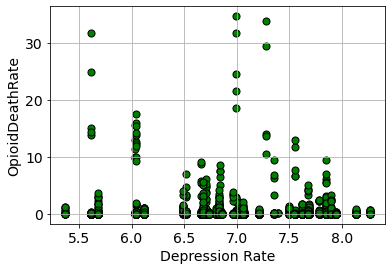

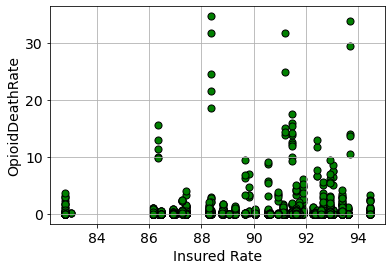

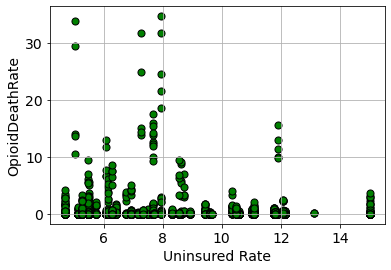

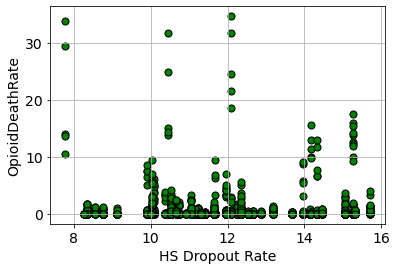

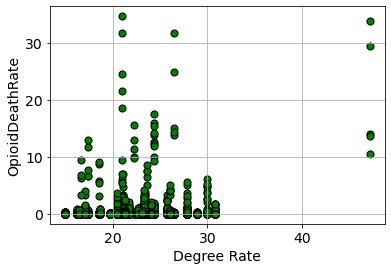

In [63]:

for i in df.columns:
    df.plot.scatter(i,'OpioidDeathRate', edgecolors=(0,0,0),s=50,c='g',grid=True)

#### Standard Linear Regression Model

In [64]:
from sklearn.linear_model import LinearRegression

In [65]:
linear_model = LinearRegression(normalize=True)

In [66]:
X_linear=df.drop('OpioidDeathRate',axis=1)
y_linear=df['OpioidDeathRate']

In [68]:
linear_model.fit(X_linear,y_linear)

LinearRegression(normalize=True)

In [69]:
y_pred_linear = linear_model.predict(X_linear)

#### R-square of simple linear fit is very bad, coefficients have no meaning i.e. we did not 'learn' the function

In [70]:
RMSE_linear = np.sqrt(np.sum(np.square(y_pred_linear-y_linear)))

In [71]:
print("Root-mean-square error of linear model:",RMSE_linear)

Root-mean-square error of linear model: 108.5061490199228


In [72]:
coeff_linear = pd.DataFrame(linear_model.coef_,index=df.drop('OpioidDeathRate',axis=1).columns, columns=['Linear model coefficients'])
coeff_linear

Linear model coefficients
Population                          -3.024405e-08
OpioidPrescriptionRate              -1.232746e+01
Unemployment Rate                   -5.995172e-02
Employment Rate                      5.945963e-04
Homeless Rate                        2.245823e+01
Poverty Rate                         2.258264e-01
Depression Rate                     -4.131533e-01
Insured Rate                        -2.950404e-01
Uninsured Rate                      -3.884203e-01
HS Dropout Rate                     -3.150708e-02
Degree Rate                          6.662581e-02

In [73]:
print ("R2 value of linear model:",linear_model.score(X_linear,y_linear))

R2 value of linear model: 0.07756324449697338


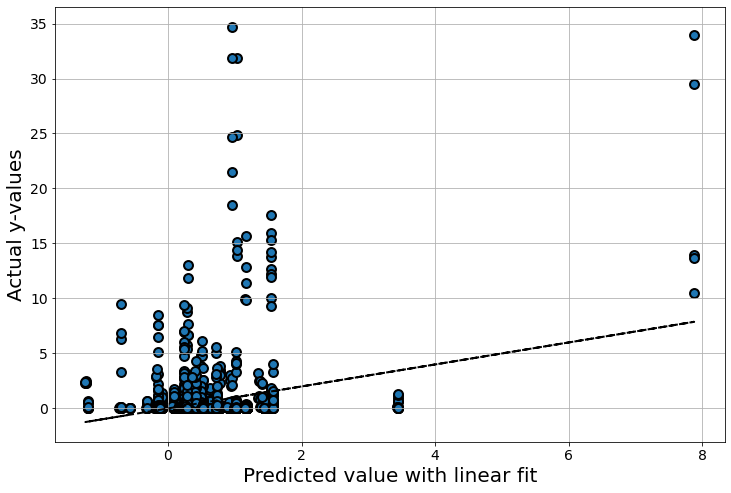

In [74]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred_linear,y_linear,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred_linear,y_pred_linear, 'k--', lw=2)

#### Create polynomial features

In [75]:
from sklearn.preprocessing import PolynomialFeatures

In [76]:
poly = PolynomialFeatures(3,include_bias=False)

In [88]:
X=df.drop('OpioidDeathRate',axis=1)
y=df['OpioidDeathRate']

X_poly = poly.fit_transform(X)
X_poly_feature_name = poly.get_feature_names()
print(X_poly_feature_name)
print(len(X_poly_feature_name))

AttributeError: 'LinearRegression' object has no attribute 'fit_transform'

In [81]:
df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly.head()

x0         x1        x2         x3        x4         x5         x6  \
0  22.573821  32.846937  0.029197  12.030360  7.390020  82.995965  13.111740   
1  22.573821  32.846937  0.029197  12.030360  7.390020  82.995965  13.111740   
2  22.573821  32.846937  0.029197  12.030360  7.390020  82.995965  13.111740   
3  34.606924  33.314549  0.007057  16.041858  6.659997  90.527775   8.636346   
4  34.606924  33.314549  0.007057  16.041858  6.659997  90.527775   8.636346   

          x7         x8         x0^2        x0 x1     x0 x2       x0 x3  \
0  10.002771  19.870369   509.577400   741.480888  0.659094  271.571189   
1  10.002771  19.870369   509.577400   741.480888  0.659094  271.571189   
2  10.002771  19.870369   509.577400   741.480888  0.659094  271.571189   
3  13.969956  18.544552  1197.639204  1152.914088  0.244213  555.159370   
4  13.969956  18.544552  1197.639204  1152.914088  0.244213  555.159370   

        x0 x4        x0 x5       x0 x6       x0 x7       x0 x8         x1^2  \
0  166.820994  1873.536070  295.982083  225.800764  448.550167  1078.921292   
1  166.820994  1873.536070  295.982083  225.800764  448.550167  1078.921292   
2  166.820994  1873.536070  295.982083  225.800764  448.550167  1078.921292   
3  230.482009  3132.887852  298.877359  483.457201  641.769911  1109.859205   
4  230.482009  3132.887852  298.877359  483.457201  641.769911  1109.859205   

      x1 x2       x1 x3       x1 x4        x1 x5       x1 x6       x1 x7  \
0  0.959041  395.160473  242.739531  2726.163264  430.680516  328.560393   
1  0.959041  395.160473  242.739531  2726.163264  430.680516  328.560393   
2  0.959041  395.160473  242.739531  2726.163264  430.680516  328.560393   
3  0.235093  534.427277  221.874797  3015.892040  287.715964  465.402782   
4  0.235093  534.427277  221.874797  3015.892040  287.715964  465.402782   

        x1 x8      x2^2     x2 x3     x2 x4     x2 x5     x2 x6     x2 x7  \
0  652.680781  0.000852  0.351254  0.215768  2.423256  0.382827  0.292054   
1  652.680781  0.000852  0.351254  0.215768  2.423256  0.382827  0.292054   
2  652.680781  0.000852  0.351254  0.215768  2.423256  0.382827  0.292054   
3  617.803400  0.000050  0.113204  0.046998  0.638834  0.060945  0.098583   
4  617.803400  0.000050  0.113204  0.046998  0.638834  0.060945  0.098583   

      x2 x8        x3^2       x3 x4        x3 x5       x3 x6       x3 x7  \
0  0.580161  144.729556   88.904602   998.471319  157.738954  120.336934   
1  0.580161  144.729556   88.904602   998.471319  157.738954  120.336934   
2  0.580161  144.729556   88.904602   998.471319  157.738954  120.336934   
3  0.130865  257.341214  106.838726  1452.233729  138.543032  224.104049   
4  0.130865  257.341214  106.838726  1452.233729  138.543032  224.104049   

        x3 x8       x4^2       x4 x5      x4 x6      x4 x7       x4 x8  \
0  239.047694  54.612399  613.341859  96.896027  73.920680  146.842432   
1  239.047694  54.612399  613.341859  96.896027  73.920680  146.842432   
2  239.047694  54.612399  613.341859  96.896027  73.920680  146.842432   
3  297.489076  44.355559  602.914703  57.518035  93.039862  123.506660   
4  297.489076  44.355559  602.914703  57.518035  93.039862  123.506660   

          x5^2        x5 x6        x5 x7        x5 x8        x6^2       x6 x7  \
0  6888.330223  1088.221550   830.189636  1649.160493  171.917737  131.153737   
1  6888.330223  1088.221550   830.189636  1649.160493  171.917737  131.153737   
2  6888.330223  1088.221550   830.189636  1649.160493  171.917737  131.153737   
3  8195.278061   781.829156  1264.669014  1678.797047   74.586466  120.649367   
4  8195.278061   781.829156  1264.669014  1678.797047   74.586466  120.649367   

        x6 x8        x7^2       x7 x8        x8^2          x0^3       x0^2 x1  \
0  260.535127  100.055428  198.758756  394.831584  11503.109083  16738.056929   
1  260.535127  100.055428  198.758756  394.831584  11503.109083  16738.056929   
2  260.535127  100.055428  198.758756  394.831584  

In [82]:
df_poly['OpioidDeathRate']=df['OpioidDeathRate']
df_poly.head()

x0         x1        x2         x3        x4         x5         x6  \
0  22.573821  32.846937  0.029197  12.030360  7.390020  82.995965  13.111740   
1  22.573821  32.846937  0.029197  12.030360  7.390020  82.995965  13.111740   
2  22.573821  32.846937  0.029197  12.030360  7.390020  82.995965  13.111740   
3  34.606924  33.314549  0.007057  16.041858  6.659997  90.527775   8.636346   
4  34.606924  33.314549  0.007057  16.041858  6.659997  90.527775   8.636346   

          x7         x8         x0^2        x0 x1     x0 x2       x0 x3  \
0  10.002771  19.870369   509.577400   741.480888  0.659094  271.571189   
1  10.002771  19.870369   509.577400   741.480888  0.659094  271.571189   
2  10.002771  19.870369   509.577400   741.480888  0.659094  271.571189   
3  13.969956  18.544552  1197.639204  1152.914088  0.244213  555.159370   
4  13.969956  18.544552  1197.639204  1152.914088  0.244213  555.159370   

        x0 x4        x0 x5       x0 x6       x0 x7       x0 x8         x1^2  \
0  166.820994  1873.536070  295.982083  225.800764  448.550167  1078.921292   
1  166.820994  1873.536070  295.982083  225.800764  448.550167  1078.921292   
2  166.820994  1873.536070  295.982083  225.800764  448.550167  1078.921292   
3  230.482009  3132.887852  298.877359  483.457201  641.769911  1109.859205   
4  230.482009  3132.887852  298.877359  483.457201  641.769911  1109.859205   

      x1 x2       x1 x3       x1 x4        x1 x5       x1 x6       x1 x7  \
0  0.959041  395.160473  242.739531  2726.163264  430.680516  328.560393   
1  0.959041  395.160473  242.739531  2726.163264  430.680516  328.560393   
2  0.959041  395.160473  242.739531  2726.163264  430.680516  328.560393   
3  0.235093  534.427277  221.874797  3015.892040  287.715964  465.402782   
4  0.235093  534.427277  221.874797  3015.892040  287.715964  465.402782   

        x1 x8      x2^2     x2 x3     x2 x4     x2 x5     x2 x6     x2 x7  \
0  652.680781  0.000852  0.351254  0.215768  2.423256  0.382827  0.292054   
1  652.680781  0.000852  0.351254  0.215768  2.423256  0.382827  0.292054   
2  652.680781  0.000852  0.351254  0.215768  2.423256  0.382827  0.292054   
3  617.803400  0.000050  0.113204  0.046998  0.638834  0.060945  0.098583   
4  617.803400  0.000050  0.113204  0.046998  0.638834  0.060945  0.098583   

      x2 x8        x3^2       x3 x4        x3 x5       x3 x6       x3 x7  \
0  0.580161  144.729556   88.904602   998.471319  157.738954  120.336934   
1  0.580161  144.729556   88.904602   998.471319  157.738954  120.336934   
2  0.580161  144.729556   88.904602   998.471319  157.738954  120.336934   
3  0.130865  257.341214  106.838726  1452.233729  138.543032  224.104049   
4  0.130865  257.341214  106.838726  1452.233729  138.543032  224.104049   

        x3 x8       x4^2       x4 x5      x4 x6      x4 x7       x4 x8  \
0  239.047694  54.612399  613.341859  96.896027  73.920680  146.842432   
1  239.047694  54.612399  613.341859  96.896027  73.920680  146.842432   
2  239.047694  54.612399  613.341859  96.896027  73.920680  146.842432   
3  297.489076  44.355559  602.914703  57.518035  93.039862  123.506660   
4  297.489076  44.355559  602.914703  57.518035  93.039862  123.506660   

          x5^2        x5 x6        x5 x7        x5 x8        x6^2       x6 x7  \
0  6888.330223  1088.221550   830.189636  1649.160493  171.917737  131.153737   
1  6888.330223  1088.221550   830.189636  1649.160493  171.917737  131.153737   
2  6888.330223  1088.221550   830.189636  1649.160493  171.917737  131.153737   
3  8195.278061   781.829156  1264.669014  1678.797047   74.586466  120.649367   
4  8195.278061   781.829156  1264.669014  1678.797047   74.586466  120.649367   

        x6 x8        x7^2       x7 x8        x8^2          x0^3       x0^2 x1  \
0  260.535127  100.055428  198.758756  394.831584  11503.109083  16738.056929   
1  260.535127  100.055428  198.758756  394.831584  11503.109083  16738.056929   
2  260.535127  100.055428  198.758756  394.831584  

In [83]:
X_train=df_poly.drop('OpioidDeathRate',axis=1)
y_train=df_poly['OpioidDeathRate']

#### Polynomial model without regularization and cross-validation

In [84]:
poly = LinearRegression(normalize=True)

In [85]:
model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)

Root-mean-square error of simple polynomial model: 98.82372284327641


In [86]:
coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('OpioidDeathRate',axis=1).columns, 
                          columns=['Coefficients polynomial model'])
coeff_poly

Coefficients polynomial model
x0                        -2.249421e+12
x1                         5.810079e+11
x2                        -1.566243e+13
x3                        -2.940443e+09
x4                        -2.634695e+11
x5                         4.496279e+10
x6                         2.941950e+11
x7                         6.503340e+11
x8                         3.266743e+11
x0^2                      -2.281315e+09
x0 x1                      9.652536e+09
x0 x2                      1.121561e+12
x0 x3                      1.294641e+10
x0 x4                      5.349965e+10
x0 x5                      4.760170e+09
x0 x6                     -8.088037e+08
x0 x7                     -5.767960e+09
x0 x8                     -1.119769e+10
x1^2                       8.137218e+09
x1 x2                     -1.141104e+12
x1 x3                      1.188938e+10
x1 x4                     -3.354044e+10
x1 x5                     -8.165956e+09
x1 x6                     -2.009111e+09
x1 x7                     -2.956827e+09
x1 x8                     -1.030306e+10
x2^2                      -1.503292e+14
x2 x3                     -3.824432e+12
x2 x4                      1.149789e+12
x2 x5                      1.471543e+11
x2 x6                      1.198787e+12
x2 x7                     -2.448778e+11
x2 x8                      1.816965e+12
x3^2                      -1.444134e+10
x3 x4                     -1.498482e+10
x3 x5                      1.306802e+09
x3 x6                      1.015654e+10
x3 x7                      1.700949e+09
x3 x8                      8.844837e+09
x4^2                       2.394099e+10
x4 x5                     -8.454803e+09
x4 x6                     -5.087508e+10
x4 x7                     -7.655885e+09
x4 x8                      5.320795e+09
x5^2                      -8.495002e+08
x5 x6                     -4.874947e+09
x5 x7                      3.746091e+08
x5 x8                      1.953276e+09
x6^2                      -4.823200e+10
x6 x7                     -2.145221e+10
x6 x8                      1.056224e+10
x7^2                      -1.348549e+10
x7 x8                      1.645451e+09
x8^2                       4.250183e+09
x0^3                      -1.398808e+08
x0^2 x1                    1.383681e+08
x0^2 x2                    3.570679e+10
x0^2 x3                    2.664018e+07
x0^2 x4                   -9.915706e+08
x0^2 x5                    5.510728e+07
x0^2 x6                    5.239535e+08
x0^2 x7                    4.042232e+07
x0^2 x8                    7.169592e+07
x0 x1^2                   -2.948355e+08
x0 x1 x2                   8.663152e+09
x0 x1 x3                   1.567129e+08
x0 x1 x4                   7.600932e+08
x0 x1 x5                   6.667254e+04
x0 x1 x6                  -2.214219e+08
x0 x1 x7                  -2.994735e+08
x0 x1 x8                   2.290958e+06
x0 x2^2                    9.905701e+11
x0 x2 x3                  -5.105366e+10
x0 x2 x4                  -1.709083e+11
x0 x2 x5                   1.205447e+10
x0 x2 x6                   1.240936e+11
x0 x2 x7                   5.042244e+09
x0 x2 x8                  -8.247821e+10
x0 x3^2                    1.673897e+08
x0 x3 x4                   1.704900e+08
x0 x3 x5                   4.903616e+07
x0 x3 x6                   4.270599e+08
x0 x3 x7                  -3.301680e+08
x0 x3 x8                  -5.539881e+08
x0 x4^2                    3.624289e+09
x0 x4 x5                   2.006490e+08
x0 x4 x6                   1.474655e+09
x0 x4 x7                   1.171523e+08
x0 x4 x8                  -7.250898e+08
x0 x5^2                    8.693381e+07
x0 x5 x6                  -2.359619e+08
x0 x5 x7                   1.420660e+08
x0 x5 x8                   7.732172e+07
x0 x6^2                    4.332754e+08
x0 x6 x7                   2.282051e+07
x0 x6 x8                   1.946187e+08
x0 x7^2                   -2.261526e+08
x0 x7 x8                   5.859182e+08
x0 x8^2                    5.122336e+08
x1^3      

#### Add Latitude and Logitute data for the States

In [43]:
file_name = dest_folder + '\Data\statelatlong.csv'

df_US_latlon = pd.read_csv(file_name)
df_US_latlon.head(10)

df_data_analysis_US = pd.merge(df_data_analysis_slice, df_US_latlon)

df_data_analysis_US.head(10)

State State Name  Population  OpioidPrescriptionRate  OpioidDeathRate  \
0    AK     Alaska      739795                0.004055         0.132469   
1    AK     Alaska      739795                0.002298         0.156800   
2    AK     Alaska      739795                0.000000         0.159504   
3    AL    Alabama     4874747                0.000000         0.008267   
4    AL    Alabama     4874747                0.000000         0.000000   
5    AL    Alabama     4874747                0.000000         0.000000   
6    AL    Alabama     4874747                0.000000         0.006236   
7    AL    Alabama     4874747                0.000000         0.083286   
8    AL    Alabama     4874747                0.000000         3.172595   
9    AL    Alabama     4874747                0.000000         0.034463   

   Unemployment Rate  Employment Rate  Homeless Rate  Poverty Rate  \
0          22.573821        32.846937       0.029197     12.030360   
1          22.573821        32.846937       0.029197     12.030360   
2          22.573821        32.846937       0.029197     12.030360   
3          34.606924        33.314549       0.007057     16.041858   
4          34.606924        33.314549       0.007057     16.041858   
5          34.606924        33.314549       0.007057     16.041858   
6          34.606924        33.314549       0.007057     16.041858   
7          34.606924        33.314549       0.007057     16.041858   
8          34.606924        33.314549       0.007057     16.041858   
9          34.606924        33.314549       0.007057     16.041858   

   Depression Rate  Insured Rate  Uninsured Rate  HS Dropout Rate  \
0         7.390020     82.995965       13.111740        10.002771   
1         7.390020     82.995965       13.111740        10.002771   
2         7.390020     82.995965       13.111740        10.002771   
3         6.659997     90.527775        8.636346        13.969956   
4         6.659997     90.527775        8.636346        13.969956   
5         6.659997     90.527775        8.636346        13.969956   
6         6.659997     90.527775        8.636346        13.969956   
7         6.659997     90.527775        8.636346        13.969956   
8         6.659997     90.527775        8.636346        13.969956   
9         6.659997     90.527775        8.636346        13.969956   

   Degree Rate   Latitude   Longitude     City  
0    19.870369  61.302501 -158.775020   Alaska  
1    19.870369  61.302501 -158.775020   Alaska  
2    19.870369  61.302501 -158.775020   Alaska  
3    18.544552  32.601011  -86.680736  Alabama  
4    18.544552  32.601011  -86.680736  Alabama  
5    18.544552  32.601011  -86.680736  Alabama  
6    18.544552  32.601011  -86.680736  Alabama  
7    18.544552  32.601011  -86.680736  Alabama  
8    18.544552  32.601011  -86.680736  Alabama  
9    18.544552  32.601011  -86.680736  Alabama

#### Opioid Prescription Rate vs Opioid Death Rates

#### Correlatioin

In [44]:
df_data_analysis_slice.corr()

Population  OpioidPrescriptionRate  OpioidDeathRate  \
Population                1.000000               -0.079806         0.011127   
OpioidPrescriptionRate   -0.079806                1.000000        -0.007270   
OpioidDeathRate           0.011127               -0.007270         1.000000   
Unemployment Rate         0.194582                0.023906         0.016523   
Employment Rate          -0.080903               -0.046789         0.010686   
Homeless Rate             0.375893               -0.035033         0.204712   
Poverty Rate              0.102332                0.105878         0.029946   
Depression Rate          -0.591330               -0.006788        -0.036953   
Insured Rate             -0.307285                0.011394         0.071451   
Uninsured Rate            0.328725                0.004134        -0.076614   
HS Dropout Rate           0.494351                0.003155        -0.009913   
Degree Rate               0.113528               -0.099723         0.112109   

                        Unemployment Rate  Employment Rate  Homeless Rate  \
Population                       0.194582        -0.080903       0.375893   
OpioidPrescriptionRate           0.023906        -0.046789      -0.035033   
OpioidDeathRate                  0.016523         0.010686       0.204712   
Unemployment Rate                1.000000        -0.653801       0.143327   
Employment Rate                 -0.653801         1.000000      -0.076121   
Homeless Rate                    0.143327        -0.076121       1.000000   
Poverty Rate                     0.682724        -0.553809      -0.058700   
Depression Rate                 -0.118638        -0.008295      -0.101543   
Insured Rate                    -0.105930         0.007639       0.209464   
Uninsured Rate                   0.161492        -0.043212      -0.166852   
HS Dropout Rate                  0.556777        -0.549846       0.131761   
Degree Rate                     -0.362013         0.591444       0.370330   

                        Poverty Rate  Depression Rate  Insured Rate  \
Population                  0.102332        -0.591330     -0.307285   
OpioidPrescriptionRate      0.105878        -0.006788      0.011394   
OpioidDeathRate             0.029946        -0.036953      0.071451   
Unemployment Rate           0.682724        -0.118638     -0.105930   
Employment Rate            -0.553809        -0.008295      0.007639   
Homeless Rate              -0.058700        -0.101543      0.209464   
Poverty Rate                1.000000        -0.174882     -0.313487   
Depression Rate            -0.174882         1.000000      0.343013   
Insured Rate               -0.313487         0.343013      1.000000   
Uninsured Rate              0.397324        -0.403040     -0.970171   
HS Dropout Rate             0.672777        -0.296072     -0.449892   
Degree Rate                -0.600589         0.092742      0.133891   

                        Uninsured Rate  HS Dropout Rate  Degree Rate  
Population                    0.328725         0.494351     0.113528  
OpioidPrescriptionRate        0.004134         0.003155    -0.099723  
OpioidDeathRate              -0.076614        -0.009913     0.112109  
Unemployment Rate             0.161492         0.556777    -0.362013  
Employment Rate              -0.043212        -0.549846     0.591444  
Homeless Rate                -0.166852         0.131761     0.370330  
Poverty Rate                  0.397324         0.672777    -0.600589  
Depression Rate              -0.403040        -0.296072     0.092742  
Insured Rate                 -0.970171        -0.449892     0.133891  
Uninsured Rate                1.000000         0.489902    -0.207696  
HS Dropout Rate               0.489902         1.000000    -0.460159  
Degree Rate                  -0.207696        -0.460159     1.000000

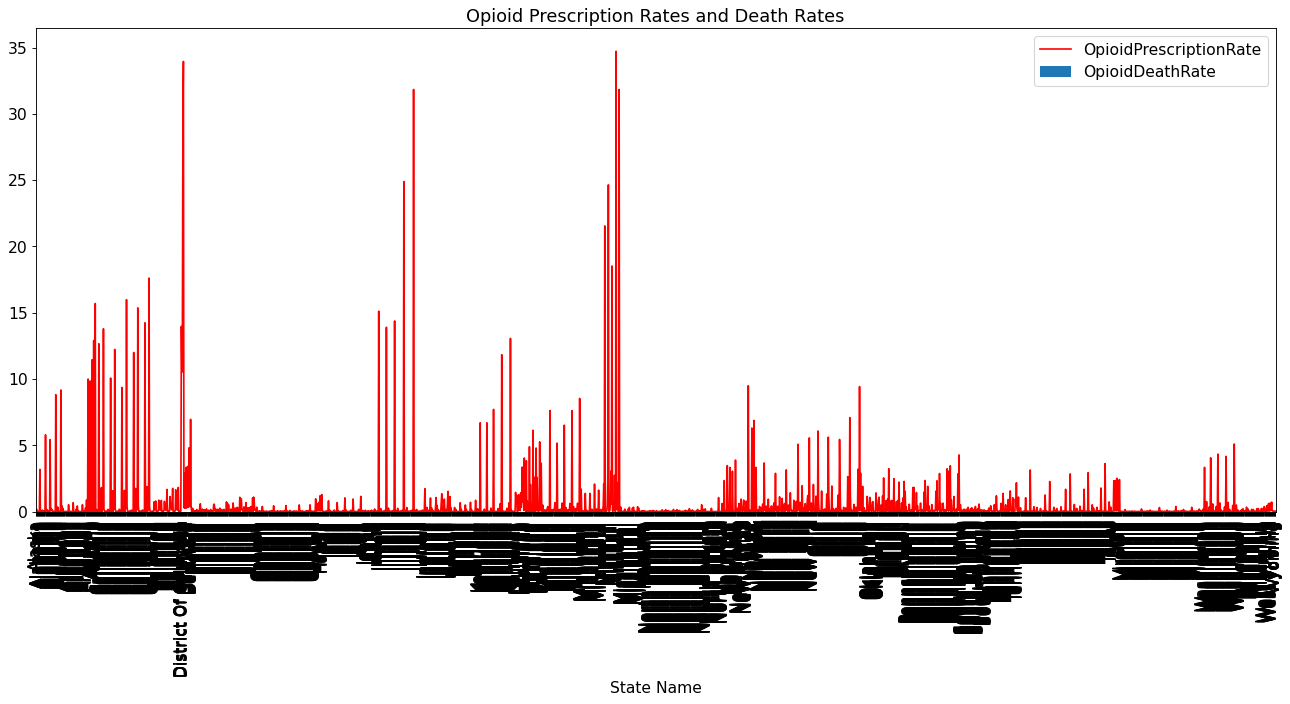

In [45]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()

#plt.figure()
#fig = plt.figure(figsize=(3,10)

df_data_analysis_US.plot(kind='bar',x='State Name', figsize=(20,8), y='OpioidPrescriptionRate', ax=ax)
df_data_analysis_US.plot(kind='line',x='State Name', y='OpioidDeathRate', color='red',ax=ax)

ax.set_title('Opioid Prescription Rates and Death Rates', fontsize=16)
plt.rcParams.update({'font.size': 14})
plt.xticks(rotation='vertical')

plt.show()

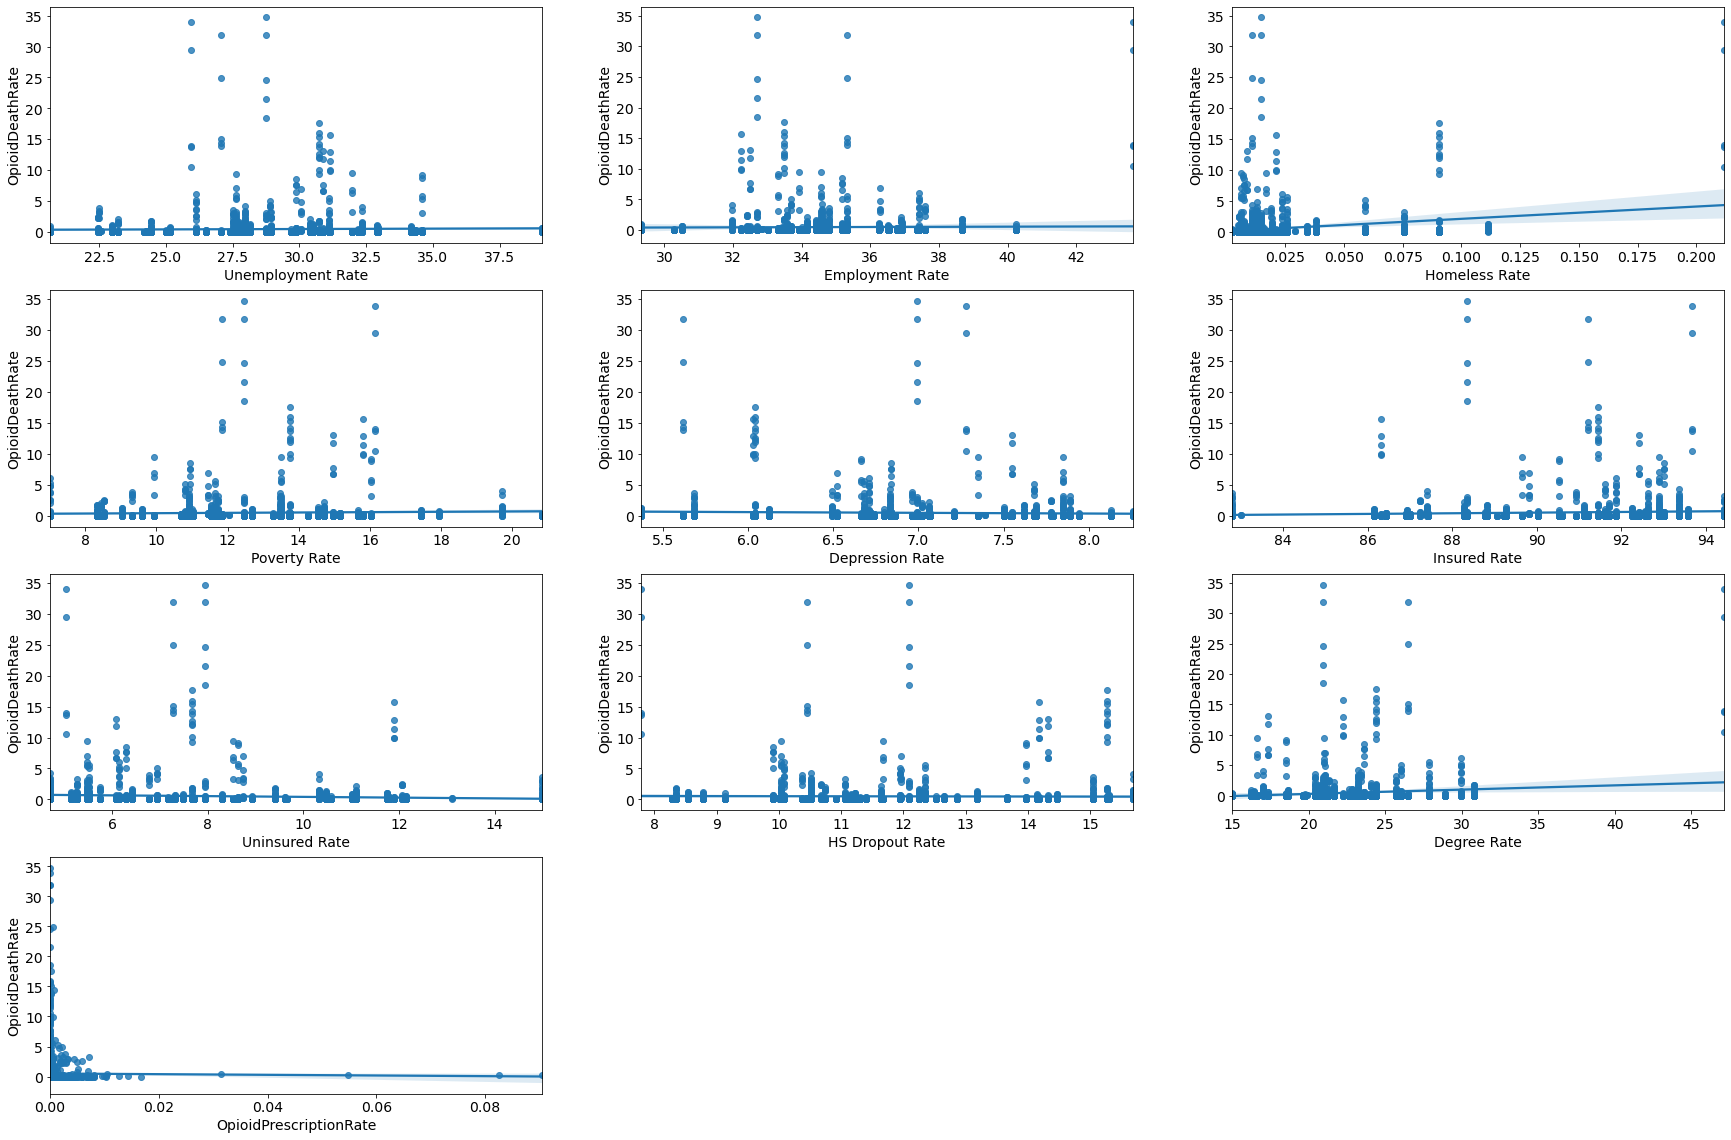

In [46]:
#==============================================================================
#  Plots on two different Figures and sets the size of the figures
#==============================================================================

# figure size = (width,height)
f1 = plt.figure(figsize=(30,20))
#f2 = plt.figure(figsize=(30,10))

#------------------------------------------------------------------------------
#  Figure 1 with 6 plots
#------------------------------------------------------------------------------

# plot one
# Plot column labeled Unemploymnet Rate
# subplot(4 Rows, 3 Columns, First subplot,)
ax1 = f1.add_subplot(4,3,1)
ax1 = sn.regplot(x="Unemployment Rate", y="OpioidDeathRate", data=df_data_analysis_US)

# plot two
# plot column labeled Employment Rate
# subplot(4 Rows, 3 Columns, Second subplot)
ax2 = f1.add_subplot(4,3,2)
ax2 = sn.regplot(x="Employment Rate", y="OpioidDeathRate", data=df_data_analysis_US)

# plot three
# plot column Homeless Rate
# subplot(4 Rows, 3 Columns, Third subplot)
ax3 = f1.add_subplot(4,3,3)
ax3 = sn.regplot(x="Homeless Rate", y="OpioidDeathRate", data=df_data_analysis_US)

# plot four
# plot column labeled Poverty Rate
# subplot(4 Rows, 3 Columns, Fourth subplot)
ax4 = f1.add_subplot(4,3,4)
ax4 = sn.regplot(x="Poverty Rate", y="OpioidDeathRate", data=df_data_analysis_US)

# plot five
# plot column labeled Depression Rate
# subplot(4 Rows, 3 Columns, Fifth subplot)
ax5 = f1.add_subplot(4,3,5)
ax5 = sn.regplot(x="Depression Rate", y="OpioidDeathRate", data=df_data_analysis_US)

# plot six
# plot column labeled Insured Rate
# subplot(4 Rows, 3 Columns, Sixth subplot)
ax6 = f1.add_subplot(4,3,6)
ax6 = sn.regplot(x="Insured Rate", y="OpioidDeathRate", data=df_data_analysis_US)

# plot seven
# Curve 1: plot column labeled Uninsured Rate
# subplot(4 Rows, 3 Columns, Seventh subplot)
ax7 = f1.add_subplot(4,3,7)
ax7 = sn.regplot(x="Uninsured Rate", y="OpioidDeathRate", data=df_data_analysis_US)

# plot eight
# Curve 1: plot column labeled HS Dropout Rate
# subplot(4 Rows, 3 Columns, Eight subplot)
ax8 = f1.add_subplot(4,3,8)
ax8 = sn.regplot(x="HS Dropout Rate", y="OpioidDeathRate", data=df_data_analysis_US)

# plot nine
# Curve 1: plot column labeled Degree Rate
# subplot(4 Rows, 3 Columns, Nitnth subplot)
ax9 = f1.add_subplot(4,3,9)
ax9 = sn.regplot(x="Degree Rate", y="OpioidDeathRate", data=df_data_analysis_US)

# plot ten
# Curve 1: plot column labeled Degree Rate
# subplot(4 Rows, 3 Columns, Tenth subplot)
ax10 = f1.add_subplot(4,3,10)
ax10 = sn.regplot(x="OpioidPrescriptionRate", y="OpioidDeathRate", data=df_data_analysis_US)


plt.show()


#### Plot the data on US Map

In [47]:
COORDINATES = (37, -102)
MAX_COUNT = len(df_data_analysis_US)

file_name = dest_folder + '\Data\states_geo.json'

with open(file_name, "r") as read_file:
    states = json.load(read_file)



import plotly.express as px

fig = px.choropleth(df_data_analysis_US,
                        locations='State', 
                        color='OpioidPrescriptionRate',
                        color_continuous_scale="Viridis",
                        range_color=(0.0, 1.0),
                        scope="usa",
                        labels={'Opioid Prescription Rate'}
                    )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()



In [109]:
"""
map_opioid = folium.Map(location=COORDINATES, zoom_start=3)


map_opioid.choropleth(
 geo_data=file_name,
 data=df_data_analysis_US,
 columns=['State Name', 'Opioid Prescription Rate'],   
 key_on='features.properties.NAME',
 fill_color='YlGn',
 fill_opacity=0.9,
 line_opacity=0.5,
 legend_name='Opioid Prescription Rate vs Death Rate'
)


# folium.LayerControl().add_to(map_opioid)

for each in df_data_analysis_US[0:MAX_COUNT].iterrows():
   folium.Circle(
      location=[each[1]['Latitude'], each[1]['Longitude']],
      popup=each[1]['State'],
      radius=each[1]['Opioid Death Rate']*1000000,
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(map_opioid)

map_opioid
"""
#map_opioid.save('US_Opioid_2017.html')

"\nmap_opioid = folium.Map(location=COORDINATES, zoom_start=3)\n\n\nmap_opioid.choropleth(\n geo_data=file_name,\n data=df_data_analysis_US,\n columns=['State Name', 'Opioid Prescription Rate'],   \n key_on='features.properties.NAME',\n fill_color='YlGn',\n fill_opacity=0.9,\n line_opacity=0.5,\n legend_name='Opioid Prescription Rate vs Death Rate'\n)\n\n\n# folium.LayerControl().add_to(map_opioid)\n\nfor each in df_data_analysis_US[0:MAX_COUNT].iterrows():\n   folium.Circle(\n      location=[each[1]['Latitude'], each[1]['Longitude']],\n      popup=each[1]['State'],\n      radius=each[1]['Opioid Death Rate']*1000000,\n      color='red',\n      fill=True,\n      fill_color='red'\n   ).add_to(map_opioid)\n\nmap_opioid\n"

#### Top 5 States - Opioid Death Rates

In [48]:
df_data_analysis_sorted = df_data_analysis_US.sort_values('OpioidDeathRate', ascending=False)
df_data_analysis_sorted.head()

State            State Name  Population  OpioidPrescriptionRate  \
1132    MO              Missouri     6113532                     0.0   
288     DC  District Of Columbia      693972                     0.0   
737     IL              Illinois    12802023                     0.0   
1138    MO              Missouri     6113532                     0.0   
287     DC  District Of Columbia      693972                     0.0   

      OpioidDeathRate  Unemployment Rate  Employment Rate  Homeless Rate  \
1132        34.711849          28.739524        32.697956       0.014443   
288         33.949497          25.937646        43.661704       0.211824   
737         31.834812          27.042601        35.314731       0.010584   
1138        31.833644          28.739524        32.697956       0.014443   
287         29.459402          25.937646        43.661704       0.211824   

      Poverty Rate  Depression Rate  Insured Rate  Uninsured Rate  \
1132     12.464153         6.990002     88.361360        7.949578   
288      16.138980         7.279977     93.663721        5.043431   
737      11.849690         5.620002     91.204335        7.272288   
1138     12.464153         6.990002     88.361360        7.949578   
287      16.138980         7.279977     93.663721        5.043431   

      HS Dropout Rate  Degree Rate   Latitude  Longitude                  City  
1132        12.087939    20.969875  38.304662 -92.437099              Missouri  
288          7.781294    47.120057  38.899349 -77.014567  District of Columbia  
737         10.451473    26.511435  39.739318 -89.504139              Illinois  
1138        12.087939    20.969875  38.304662 -92.437099              Missouri  
287          7.781294    47.120057  38.899349 -77.014567  District of Columbia

#### Bottom 5 States - Opioid Death Rates

In [49]:
df_data_analysis_sorted.tail()

State      State Name  Population  OpioidPrescriptionRate  \
1578    OH            Ohio    11658609                0.000240   
601     IA            Iowa     3145711                0.003624   
1583    OH            Ohio    11658609                0.000000   
600     IA            Iowa     3145711                0.000000   
1209    NC  North Carolina    10273419                0.000000   

      OpioidDeathRate  Unemployment Rate  Employment Rate  Homeless Rate  \
1578              0.0          27.619075        34.558154       0.006219   
601               0.0          22.983675        36.239820       0.005404   
1583              0.0          27.619075        34.558154       0.006219   
600               0.0          22.983675        36.239820       0.005404   
1209              0.0          29.678533        34.010099       0.009675   

      Poverty Rate  Depression Rate  Insured Rate  Uninsured Rate  \
1578     13.492176         7.850002     92.901306        5.472351   
601       9.600373         6.689998     93.587745        5.149869   
1583     13.492176         7.850002     92.901306        5.472351   
600       9.600373         6.689998     93.587745        5.149869   
1209     13.267248         7.070003     87.419777       10.580703   

      HS Dropout Rate  Degree Rate   Latitude  Longitude            City  
1578        10.035503    20.997359  40.190362 -82.669252            Ohio  
601          8.773851    22.856518  41.938317 -93.389798            Iowa  
1583        10.035503    20.997359  40.190362 -82.669252            Ohio  
600          8.773851    22.856518  41.938317 -93.389798            Iowa  
1209        12.527475    23.156848  35.214563 -79.891267  North Carolina

#### Regression Analysis - Opioid Death Rate

In [50]:
X = df_data_analysis_US[['Unemployment Rate', 'Employment Rate', 'Homeless Rate', 'Poverty Rate', 'Depression Rate', 'Insured Rate', 'Uninsured Rate', 'HS Dropout Rate', 'Degree Rate']]
Y = df_data_analysis_US[['OpioidDeathRate']]

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:        OpioidDeathRate   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     20.63
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           7.89e-34
Time:                        22:36:53   Log-Likelihood:                -5354.3
No. Observations:                2419   AIC:                         1.073e+04
Df Residuals:                    2409   BIC:                         1.079e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                30.5559      7.21

Omnibus/Prob(Omnibus) – a test of the skewness and kurtosis of the residual (characteristic #2). We hope to see a value close to zero which would indicate normalcy. The Prob (OmniKurtosis – a measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers.bus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here. In this case Omnibus is relatively high and the Prob (Omnibus) is relatively low so the data is not normal. A linear regression approach would probably be better than random guessing but likely not as good as a nonlinear approach.

Skew – a measure of data symmetry. We want to see something close to zero, indicating the residual distribution is normal. Note that this value also drives the Omnibus. This result has a large, and therefore not good, skew.

Kurtosis – a measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers.

Durbin-Watson – tests for homoscedasticity. We hope to have a value between 1 and 2. In this case, the data is close, but within limits.

Jarque-Bera (JB)/Prob(JB) – like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a confirmation of the Omnibus test. In this case we do.

Condition Number – This test measures the sensitivity of a function's output as compared to its input. When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30. 

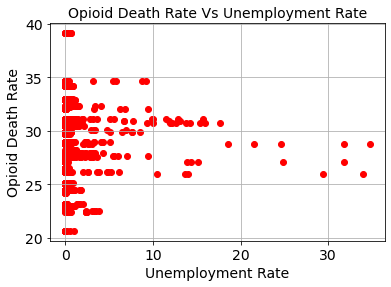

In [51]:
plt.scatter(df_data_analysis_US['OpioidDeathRate'].astype(float),df_data_analysis_US['Unemployment Rate'].astype(float), color = 'r')
plt.title('Opioid Death Rate Vs Unemployment Rate', fontsize=14)
plt.xlabel('Unemployment Rate', fontsize=14)
plt.ylabel('Opioid Death Rate', fontsize=14)
plt.grid(True)
plt.show()

#### Regression Analysis - Opioid Prescription Rate

In [52]:
X = df_data_analysis_US[['Unemployment Rate', 'Employment Rate', 'Homeless Rate', 'Poverty Rate', 'Depression Rate', 'Insured Rate', 'Uninsured Rate', 'HS Dropout Rate', 'Degree Rate']]
Y = df_data_analysis_US[['OpioidPrescriptionRate']]

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                              OLS Regression Results                              
Dep. Variable:     OpioidPrescriptionRate   R-squared:                       0.026
Model:                                OLS   Adj. R-squared:                  0.022
Method:                     Least Squares   F-statistic:                     7.127
Date:                    Wed, 02 Dec 2020   Prob (F-statistic):           2.95e-10
Time:                            22:37:37   Log-Likelihood:                 10622.
No. Observations:                    2419   AIC:                        -2.122e+04
Df Residuals:                        2409   BIC:                        -2.117e+04
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

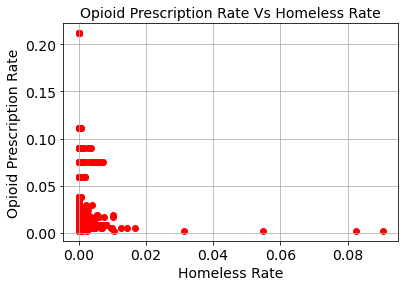

In [53]:
plt.scatter(df_data_analysis_US['OpioidPrescriptionRate'].astype(float),df_data_analysis_US['Homeless Rate'].astype(float), color = 'r')
plt.title('Opioid Prescription Rate Vs Homeless Rate', fontsize=14)
plt.xlabel('Homeless Rate', fontsize=14)
plt.ylabel('Opioid Prescription Rate', fontsize=14)
plt.grid(True)
plt.show()


Linear regression model is not suffiecient in this case and we have to use non-linear regression model.

In [54]:


# Import function to create training and test set splits
from sklearn.model_selection import train_test_split
# Import function to automatically create polynomial features! 
from sklearn.preprocessing import PolynomialFeatures
# Import Linear Regression and a regularized regression function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
# Finally, import function to make a machine learning pipeline
from sklearn.pipeline import make_pipeline

In [55]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000

In [56]:
# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 8

In [57]:
# Test/train split
X = df_data_analysis_US[['Unemployment Rate', 'Employment Rate', 'Homeless Rate', 'Poverty Rate', 'Depression Rate', 'Insured Rate', 'Uninsured Rate', 'HS Dropout Rate', 'Degree Rate']]
Y = df_data_analysis_US[['OpioidDeathRate']]

X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=test_set_fraction)

NameError: name 'test_set_fraction' is not defined

## Results and Discussion <a name="results"></a>

When you compare **West Virginia** the state with the **highest opioid death rate**  with the **North Dakota** the state with the **lowest opioid death rate** one notices that the socio-economic factors <br>

<table>
    <tr><td></td><td><b>West Virginia</b></td><td><b>North Dakota</b></td></tr>
    <tr><td><b>Unemployment rate</b></td><td>39.099</td><td>20.651</td></tr> 
    <tr><td><b>Employment rate</b></td><td>30.509</td><td>40.243</td></tr>
    <tr><td><b>Homeless rate</b></td><td>0.0103</td><td>0.0048</td></tr> 
    <tr><td><b>Poverty rate</b></td><td>17.952</td><td>10.987</td></tr>
    <tr><td><b>Depression rate</b></td><td>8.260</td><td>6.800</td></tr>
    <tr><td><b>Insured rate</b></td><td>92.573</td><td>91.607</td></tr>
    <tr><td><b>Uninsured rate</b></td><td>7.324</td><td>7.678</td></tr>
    <tr><td><b>HS Dropout Rate rate</b></td><td>15.309</td><td>9.134</td></tr>
    <tr><td><b>Degree rate</b></td><td>16.410</td><td>22.637</td></tr>
    <tr><td><b>Opioid Prescription rate</b></td><td>3.733</td><td>3.428</td></tr>
</table>

have an impact on the opioid death rate.The state with the highest opioid death rate has the highest enemploymnet rate, homless rate, porverty rate, depression rate, High School Dropout rate and Opioid Prescripition rate.

Further analysis of the linear dependencies on the two variables - opioid death rate and individual socio-economic factors - results shown below

<table>
    <tr><td></td><td><b>Pearson Correlation Coefficient</b></td><td><b>P-value</b></td></tr>
    <tr><td><b>Unemployment Rate vs Opioid Death Rate</b></td><td>0.28010068903143265</td><td>0.04650549259363219</td></tr> 
    <tr><td><b>Employment Rate vs Opioid Death Rate</b></td><td>0.10425512143745068</td><td>0.46657670297060405</td></tr>
    <tr><td><b>Homeless Rate vs Opioid Death Rate</b></td><td>0.16816118599253874</td><td>0.23817466877861332</td></tr> 
    <tr><td><b>Poverty Rate vs Opioid Death Rat</b></td><td>0.007456071165732117</td><td>0.9585863588975125</td></tr>
    <tr><td><b>Depression Rate vs Opioid Death Rate</b></td><td>0.1427173514015973</td><td>0.3177635047469663</td></tr>
    <tr><td><b>Insured Rate vs Opioid Death Rate</b></td><td>0.30178300346351755</td><td>0.03138253740135453</td></tr>
    <tr><td><b>Uninsured Rate vs Opioid Death Rate</b></td><td>-0.3017031801271633</td><td>0.031429597696551494</td></tr>
    <tr><td><b>HS Dropout Rate vs Opioid Death Ratee</b></td><td>-0.02998984442396571</td><td>0.8345202835700284</td></tr>
    <tr><td><b>Degree Rate vs Opioid Death Rate</b></td><td>0.1427173514015973</td><td>0.3177635047469663</td></tr>
    <tr><td><b>Opioid Prescription Rate vs Opioid Death Rate</b></td><td>-0.10350138706867021</td><td>0.4698224383106909</td></tr>
</table>

indicate moderate evidence that the correlation is significant on the impact of **unemployment and insurance rate** on opioid death rate 